## Data Exploration

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
import matplotlib.pyplot as plt

### General view of the dataset

In [2]:
df = pd.read_csv('spam_1.csv')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.shape

(5572, 5)

There are `5572` data points and `5` columns: `v1`, `v2`, `Unnamed: 2`,	`Unnamed: 3`, `Unnamed: 4`


#### Drop `Unnamed: 2`,	`Unnamed: 3`, `Unnamed: 4` since they are irrelevant

In [5]:
# delete 3 unnamed columns
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

#### Rename `v1` to `Category` and `v2` to `Message`

In [6]:
df = df.rename(columns={"v1": "Label", "v2": "Message"})

In [7]:
df.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Check for missing values 

In [8]:
# check null
df.isnull().sum()

Label      0
Message    0
dtype: int64

#### Check for duplicates

In [9]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [10]:
df.shape

(5169, 2)

After dropping duplicates, the dataset goes from `5572` to `5169` rows

## Data preprocessing

### Remove special character

In [11]:
punctuation = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation))

In [12]:
df["Message"] = df["Message"].apply(lambda text: remove_punctuation(text))
df.head()

,Label,Message
0,ham,Go until jurong point crazy Available only in ...
1,ham,Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor U c already then say
4,ham,Nah I dont think he goes to usf he lives aroun...


### Remove stopwords

#### Install `nltk` (Natural Language Toolkit) 

In [13]:
# pip install nltk

In [14]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Function to remove stopwords

In [13]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

In [14]:
df["Message"] = df["Message"].apply(lambda text: remove_stopwords(text))
df.head()

,Label,Message
0,ham,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar Joking wif u oni
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say early hor U c already say
4,ham,Nah I dont think goes usf lives around though


### Lemmatizing words

In [17]:
import nltk

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Function to lemmatize the text

In [15]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

# pos_text: Part of speech, assign a tag to each token in a document to denote its part of speech

wordnet_map = {"N":  wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    pos_text = pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_text])

In [16]:
df["Message"] = df["Message"].apply(lambda text: lemmatize_words(text))
df.head()

,Label,Message
0,ham,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar Joking wif u oni
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say early hor U c already say
4,ham,Nah I dont think go usf life around though


### Check label's distribution of target vector `Category` to determine whether unbalanced or not

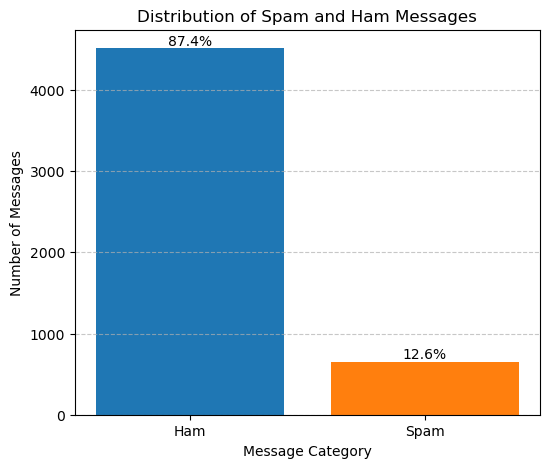

In [17]:
# Count occurrences of each label
spam_count = df['Label'].value_counts()[0]  # Count of spam messages
ham_count = df['Label'].value_counts()[1]  # Count of ham messages

# Calculate total messages
total_messages = len(df)

# Calculate percentages
spam_percent = (spam_count / total_messages) * 100
ham_percent = (ham_count / total_messages) * 100

# Set chart labels and title
labels = ['Ham', 'Spam']
title = 'Distribution of Spam and Ham Messages'

# Create the bar chart
plt.figure(figsize=(6, 5))  # Adjust figure size as needed
bars = plt.bar(labels, [spam_count, ham_count], color=["#1f77b4", "tab:orange"])

# Add percentage labels on top of each bar
plt.gca().text(bars[0].get_x() + bars[0].get_width() / 2, bars[0].get_height() + 1, "{:.1f}%".format(spam_percent), ha='center', va='bottom')
plt.gca().text(bars[1].get_x() + bars[1].get_width() / 2, bars[1].get_height() + 1, "{:.1f}%".format(ham_percent), ha='center', va='bottom')

# Customize the chart further (optional)
plt.xlabel('Message Category')
plt.ylabel('Number of Messages')
plt.title(title)
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.savefig("label_count_v1")

plt.show()

In [21]:
df['Label'].value_counts()

Label
ham     4516
spam     653
Name: count, dtype: int64

The labels are imbalanced with **87%** are ham and **13%** are spam

## Split data

In [18]:
X = df['Message']
y = df['Label']

Since there's unbalanced in class lables, **stratified partitioning** will be used because it ensures that every partition preserves the same ratio of values for the prediction target as in the original data

In [19]:
from sklearn.model_selection import train_test_split

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4135,) (1034,) (4135,) (1034,)


## Training models

### Import models from scikit-learn

In [21]:
# base models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# meta model
from sklearn.ensemble import GradientBoostingClassifier

### Initialize TfidfVectorizer

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer()

### Import  `Kfold`,  `cross_val_score`, `Pipeline`

In [23]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

### Create pipelines for base models and define baseline performance (training set) with `cross_val_score`

### Pipelines

In [25]:
# initialize LR model
lr = LogisticRegression()
lr_pl = Pipeline([('tf', TfidfVectorizer()), ('lr', lr)]) # initialize LR pipeline 

# initialize KNN model
knn = KNeighborsClassifier()
knn_pl = Pipeline([('tf', TfidfVectorizer()), ('knn', knn)]) # initialize KNN pipeline 

# initialize SVM model
svc = SVC()
svc_pl = Pipeline([('tf', TfidfVectorizer()), ('svc', svc)]) # initialize SVM pipeline 

# initialize NB model
nb = GaussianNB()
nb_pl = Pipeline([('tf', TfidfVectorizer()), ('nb', nb)]) # initialize NB pipeline 

# initialize RF model
rf = RandomForestClassifier()
rf_pl = Pipeline([('tf', TfidfVectorizer()), ('rf', rf)]) # initialize RF pipeline 

# initialize DT model
dt = DecisionTreeClassifier()
dt_pl = Pipeline([('tf', TfidfVectorizer()), ('dt', dt)])  # initialize DT pipeline 


In [26]:
pipelines = [lr_pl, knn_pl, svc_pl, rf_pl, dt_pl]

pipe_dict = {0: 'Logistic Regression', 1: 'K Nearest Neighbor', 2: 'Support Vector Machine',
             3: 'Random Forrest', 4: 'Decision Tree'}

#### Establish baseline accuracy

In [27]:
baselines = []

In [28]:
for i in range(len(pipelines)):
    pipelines[i].fit(X_train, y_train)
    pred = pipelines[i].predict(X_train)
    acc_base = accuracy_score(y_train, pred)
    baselines.append((pipe_dict[i], "score:", acc_base))

In [29]:
# for NB
nb_test = GaussianNB()
X_train_tf = tf.fit_transform(X_train)
X_test_tf = tf.transform(X_test)

# convert to array due to sparse error matrix
X_train_tf_arr = X_train_tf.toarray()
X_test_tf_arr = X_test_tf.toarray()

nb.fit(X_train_tf_arr, y_train)
nb_base_pred = nb.predict(X_train_tf_arr)
nb_base_score = accuracy_score(y_train, nb_base_pred)

In [30]:
baselines.append(('Naive Bayes', "score", nb_base_score))

In [31]:
baselines

[('Logistic Regression', 'score:', 0.9598548972188634),
 ('K Nearest Neighbor', 'score:', 0.9129383313180169),
 ('Support Vector Machine', 'score:', 0.9975816203143894),
 ('Random Forrest', 'score:', 1.0),
 ('Decision Tree', 'score:', 1.0),
 ('Naive Bayes', 'score', 0.9446191051995163)]

#### Plot for baseline accuracy

In [40]:
base_acc = []

In [41]:
for a, b, c in baselines:
    base_acc.append(c)

In [42]:
base_acc

[0.9598548972188634,
 0.9129383313180169,
 0.9975816203143894,
 1.0,
 1.0,
 0.9446191051995163]

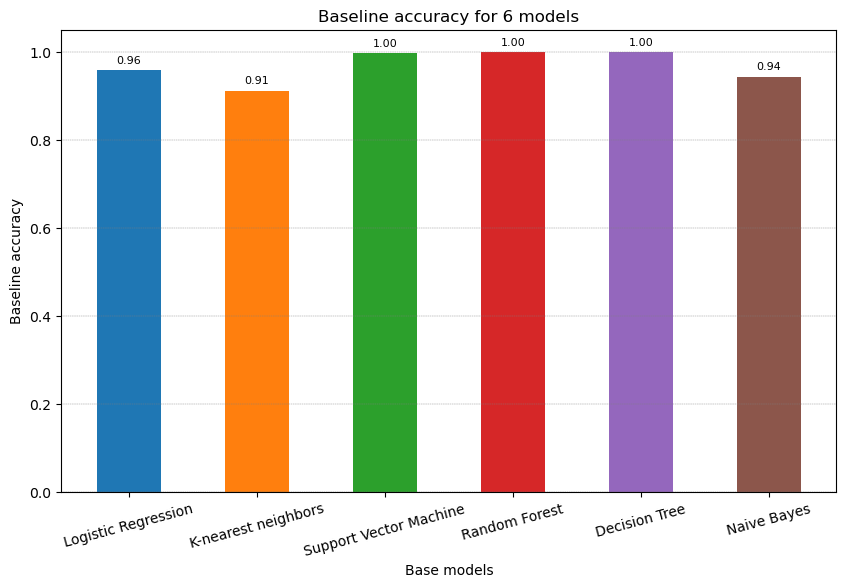

In [43]:
# Create bar plot
base_models = ["Logistic Regression", "K-nearest neighbors", 
                 "Support Vector Machine", "Random Forest", 
                  "Decision Tree", "Naive Bayes"]

base_metric = ["Accuracy"]

plt.figure(figsize=(10, 6))

bar_width = 0.5

for i in range(len(base_acc)):
    plt.bar(base_models[i], base_acc[i], bar_width)
    
    # add value on top of each bar
    y_pos = base_acc[i] + 0.01
    plt.text(base_models[i], y_pos, f"{base_acc[i]:.2f}", ha='center', va='bottom', fontsize=8)

# Customize the plot
plt.xlabel("Base models")
plt.ylabel("Baseline accuracy")
plt.title("Baseline accuracy for 6 models")
plt.xticks(rotation=15)  # Rotate x-axis labels for readability if many models
plt.grid(axis="y", color = 'gray', linestyle = '--', linewidth = 0.3)
plt.savefig("baseline_accuracy")

# Display the plot
plt.show()

### Hyperparameter tuning the models using Grid Search cross-validation

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
# search for LR
lr_param = {'penalty': ["elasticnet"], 
            'solver': ["saga"],
            'l1_ratio': [0.5, 0.7, 0.9]
           }
lr_search = GridSearchCV(lr, lr_param, cv=kfold, n_jobs=-1, scoring="accuracy").fit(X_train_tf, y_train)
print('LR random best score: ', lr_search.best_score_)
print('LR random best param: ', lr_search.best_params_)

LR random best score:  0.9417170495767836
LR random best param:  {'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}


In [34]:
# search for KNN
knn_param = {'weights': ['uniform', 'distance'],
             'metric': ['euclidean', 'manhattan'],
             'n_neighbors': [1, 5, 9]
            }
knn_search = GridSearchCV(knn, knn_param, cv=kfold, n_jobs=-1, scoring="accuracy").fit(X_train_tf, y_train)
print('KNN random best score: ', knn_search.best_score_)
print('KNN random best param: ', knn_search.best_params_)

KNN random best score:  0.939782345828295
KNN random best param:  {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}


In [35]:
# search for SVM  
svm_param = {'kernel': ['poly', 'rbf', 'sigmoid'],
             'C': [1.0, 0.1, 0.01],
             'gamma': ['scale']
            }
svm_search = GridSearchCV(svc, svm_param, cv=kfold, n_jobs=-1, scoring="accuracy").fit(X_train_tf, y_train)
print('SVM random best score: ', svm_search.best_score_)
print('SVM random best param: ', svm_search.best_params_)

SVM random best score:  0.9721886336154777
SVM random best param:  {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}


In [36]:
# search for RF
rf_param = {'n_estimators': [10, 100, 1000],
           'max_features': ['sqrt', 'log2'],
            'max_depth': [15, 25, 30]
           }
rf_search = RandomizedSearchCV(rf, rf_param, cv=kfold, n_jobs=-1, scoring="accuracy").fit(X_train_tf, y_train)
print('RF random best score: ', rf_search.best_score_)
print('RF random best param: ', rf_search.best_params_)

RF random best score:  0.9518742442563483
RF random best param:  {'n_estimators': 1000, 'max_features': 'sqrt', 'max_depth': 30}


In [37]:
# search for DT
dt_param = {'max_depth': [5, 10, 20],
            'min_samples_leaf': [20, 50, 100],
            'criterion': ["gini", "entropy"]
           }
dt_search = GridSearchCV(dt, dt_param, cv=kfold, n_jobs=-1, scoring="accuracy").fit(X_train_tf, y_train)
print('DT random best score: ', dt_search.best_score_)
print('DT random best param: ', dt_search.best_params_)

DT random best score:  0.935912938331318
DT random best param:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 20}


In [38]:
# search for NB
nb_param = {'var_smoothing': np.logspace(0,-9, num=100)}
nb_search = RandomizedSearchCV(nb, nb_param, cv=kfold, n_jobs=-1, scoring="accuracy").fit(X_train_tf_arr, y_train)
print('NB random best score: ', nb_search.best_score_)
print('NB random best param: ', nb_search.best_params_)

NB random best score:  0.947037484885127
NB random best param:  {'var_smoothing': 0.8111308307896871}


### Get out-of-fold predictions for each tuned model

In [39]:
# out-of-fold portion
# return full_y_pred, full_holdout_pred

def out_of_fold(model, X_train_tf, X_test_tf, y_train, y_test, kfold):
    # initialize arrays to store predictions
    full_y_pred = np.empty((0,))
    full_holdout_pred = np.zeros(len(X_test_tf))
    
    y_train_text = np.array(y_train)
    
    # create out-of-fold predictions for model stacking
    for fold, (train_index, test_index) in enumerate(kfold.split(X_train_tf)):
        X_train_fold, X_test_fold = X_train_tf[train_index], X_train_tf[test_index]
        y_train_fold, y_test_fold = y_train_text[train_index], y_train_text[test_index]
        
        # fit model
        model.fit(X_train_fold, y_train_fold)

        # make predictions on fold test and test sets
        y_fold_pred = model.predict_proba(X_test_fold)[:, 1]
        holdout_pred = model.predict_proba(X_test_tf)[:, 1]


        # extend full_y_pred with fold predictions
        full_y_pred = np.concatenate((full_y_pred, y_fold_pred))
        full_holdout_pred += holdout_pred
        
    print('full_y_pred', len(full_y_pred), full_y_pred)
    
    print('full_holdout_pred', len(full_holdout_pred), full_holdout_pred)
    
    return (full_y_pred, full_holdout_pred)

In [40]:
# tuned LR
lr_best = lr_search.best_params_
tuned_lr = LogisticRegression(**lr_best)

# lr oof
full_lr, holdout_lr = out_of_fold(tuned_lr, X_train_tf_arr, X_test_tf_arr, y_train, y_test, kfold)
print(full_lr, holdout_lr)

full_y_pred 4135 [0.02899038 0.05273938 0.25923709 ... 0.05279446 0.04657806 0.05279446]
full_holdout_pred 1034 [0.27249351 0.24179648 0.16562781 ... 4.61500898 0.18173498 0.19309377]
[0.02899038 0.05273938 0.25923709 ... 0.05279446 0.04657806 0.05279446] [0.27249351 0.24179648 0.16562781 ... 4.61500898 0.18173498 0.19309377]


In [41]:
# tuned KNN
knn_best = knn_search.best_params_
tuned_knn = KNeighborsClassifier(**knn_best)

# knn oof
full_knn, holdout_knn = out_of_fold(tuned_knn, X_train_tf_arr, X_test_tf_arr, y_train, y_test, kfold)
print(full_knn, holdout_knn)

full_y_pred 4135 [0.         0.         0.13610728 ... 0.         0.         0.        ]
full_holdout_pred 1034 [0.         0.         0.         ... 3.54673278 0.         0.        ]
[0.         0.         0.13610728 ... 0.         0.         0.        ] [0.         0.         0.         ... 3.54673278 0.         0.        ]


In [42]:
# tuned SVC
svm_best = svm_search.best_params_
tuned_svc = SVC(**svm_best, probability=True)

# svm oof
full_svm, holdout_svm = out_of_fold(tuned_svc, X_train_tf_arr, X_test_tf_arr, y_train, y_test, kfold)
print(full_svm, holdout_svm)

full_y_pred 4135 [1.91569497e-04 4.05719091e-02 9.43911267e-01 ... 5.79287002e-02
 1.53701232e-02 8.49432510e-02]
full_holdout_pred 1034 [9.07590327e-03 2.09016074e-03 1.08817047e-02 ... 4.99999999e+00
 5.97385312e-02 6.75003701e-02]
[1.91569497e-04 4.05719091e-02 9.43911267e-01 ... 5.79287002e-02
 1.53701232e-02 8.49432510e-02] [9.07590327e-03 2.09016074e-03 1.08817047e-02 ... 4.99999999e+00
 5.97385312e-02 6.75003701e-02]


In [43]:
# tuned RF
rf_best = rf_search.best_params_
tuned_rf = RandomForestClassifier(**rf_best)

# RF oof
full_rf, holdout_rf = out_of_fold(tuned_rf, X_train_tf_arr, X_test_tf_arr, y_train, y_test, kfold)
print(full_rf, holdout_rf)

full_y_pred 4135 [0.03251911 0.0663117  0.46302643 ... 0.0327887  0.03320435 0.05643309]
full_holdout_pred 1034 [0.18026575 0.16310273 0.16377074 ... 4.65639723 0.26751979 0.17436468]
[0.03251911 0.0663117  0.46302643 ... 0.0327887  0.03320435 0.05643309] [0.18026575 0.16310273 0.16377074 ... 4.65639723 0.26751979 0.17436468]


In [44]:
# tuned RF
dt_best = dt_search.best_params_
tuned_dt = DecisionTreeClassifier(**dt_best)

# RF oof
full_dt, holdout_dt = out_of_fold(tuned_dt, X_train_tf_arr, X_test_tf_arr, y_train, y_test, kfold)
print(full_dt, holdout_dt)

full_y_pred 4135 [0.02723881 0.02723881 0.22641509 ... 0.02769461 0.02769461 0.02769461]
full_holdout_pred 1034 [0.13835223 0.13835223 0.13835223 ... 4.45998168 0.13835223 0.13835223]
[0.02723881 0.02723881 0.22641509 ... 0.02769461 0.02769461 0.02769461] [0.13835223 0.13835223 0.13835223 ... 4.45998168 0.13835223 0.13835223]


In [45]:
# tuned NB
nb_best = nb_search.best_params_
tuned_nb = GaussianNB(**nb_best)

# RF oof
full_nb, holdout_nb = out_of_fold(tuned_nb, X_train_tf_arr, X_test_tf_arr, y_train, y_test, kfold)
print(full_nb, holdout_nb)

full_y_pred 4135 [4.21362110e-07 7.70848366e-01 9.98558218e-01 ... 2.43239370e-04
 4.85262705e-03 6.21935421e-01]
full_holdout_pred 1034 [2.32360618e-05 4.08446564e-08 4.57098780e-04 ... 5.00000000e+00
 1.95694412e-01 2.02257802e-04]
[4.21362110e-07 7.70848366e-01 9.98558218e-01 ... 2.43239370e-04
 4.85262705e-03 6.21935421e-01] [2.32360618e-05 4.08446564e-08 4.57098780e-04 ... 5.00000000e+00
 1.95694412e-01 2.02257802e-04]


### Stack models' predictions to make a new training data for meta class 

In [46]:
stack_train = np.column_stack((full_lr, full_knn, full_svm, full_rf, full_dt, full_nb))
stack_test = np.column_stack((holdout_lr, holdout_knn, holdout_svm, holdout_rf, holdout_dt, holdout_nb))

In [47]:
stack_train_df = pd.DataFrame(stack_train)
stack_train_df

,0,1,2,3,4,5
0,0.028990,0.000000,0.000192,0.032519,0.027239,4.213621e-07
1,0.052739,0.000000,0.040572,0.066312,0.027239,7.708484e-01
2,0.259237,0.136107,0.943911,0.463026,0.226415,9.985582e-01
3,0.027981,0.000000,0.000861,0.040458,0.027239,3.961595e-04
4,0.031561,0.000000,0.000206,0.032406,0.027239,2.091619e-10
...,...,...,...,...,...,...
4130,0.018410,0.000000,0.000201,0.032489,0.027695,1.047201e-06
4131,0.216366,0.304534,0.709006,0.393296,0.696203,9.999362e-01
4132,0.052794,0.000000,0.057929,0.032789,0.027695,2.432394e-04
4133,0.046578,0.000000,0.015370,0.033204,0.027695,4.852627e-03


In [48]:
stack_test_df = pd.DataFrame(stack_test)
stack_test_df

,0,1,2,3,4,5
0,0.272494,0.000000,0.009076,0.180266,0.138352,2.323606e-05
1,0.241796,0.000000,0.002090,0.163103,0.138352,4.084466e-08
2,0.165628,0.000000,0.010882,0.163771,0.138352,4.570988e-04
3,0.209852,0.000000,0.042086,0.161939,0.138352,1.226745e-02
4,0.210655,0.000000,0.007516,0.163090,0.138352,3.183029e-04
...,...,...,...,...,...,...
1029,4.329270,1.210303,4.972869,2.095155,3.300000,4.999912e+00
1030,0.266279,0.000000,0.063410,0.163102,0.138352,8.468574e-03
1031,4.615009,3.546733,5.000000,4.656397,4.459982,5.000000e+00
1032,0.181735,0.000000,0.059739,0.267520,0.138352,1.956944e-01


### Cross val score with meta model

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

meta_model = GradientBoostingClassifier(learning_rate=0.02, n_estimators=1100, n_iter_no_change=100, random_state=42)

cv_score = cross_val_score(meta_model, stack_train_df, y_train, cv=kfold, scoring="accuracy")
print("Meta mean accuracy", np.mean(cv_score))

Meta mean accuracy 0.8727932285368803


### Tuned meta model

In [50]:
meta_param = {'max_depth': [4, 6, 8], 
             'subsample': [0.5, 0.75, 1.0], 
             'min_samples_leaf': [50, 60, 70]}

meta_grid = GridSearchCV(meta_model, meta_param, cv=kfold, scoring="accuracy", n_jobs=-1).fit(stack_train_df, y_train)

print('Meta grid best score: ', meta_grid.best_score_)
print('Meta grid best param: ', meta_grid.best_params_)

Meta grid best score:  0.8737605804111246
Meta grid best param:  {'max_depth': 4, 'min_samples_leaf': 50, 'subsample': 0.5}


### Import metrics

In [51]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

### Meta model on test set

In [52]:
meta_best = meta_grid.best_params_

final_meta = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000, 
                                        n_iter_no_change=100, random_state=42,
                                       **meta_best)

# evaluate on test set
final_meta.fit(stack_train_df, y_train)
y_pred = final_meta.predict(stack_test_df)

final_acc = accuracy_score(y_test, y_pred)

In [53]:
final_acc

0.8733075435203095

### Helper function to evaluate each model on test set

In [54]:
def evaluate(models, X_train_tf, X_test_tf, y_train, y_test):
    acc_scores = []
    prec_scores = []
    rec_scores = []
    f1_scores =  []
    
    for model in models:
        model.fit(X_train_tf, y_train)
        model_pred = model.predict(X_test_tf)
        
        model_acc = accuracy_score(y_test, model_pred)
        model_prec = precision_score(y_test, model_pred, pos_label="spam")
        model_rec = recall_score(y_test, model_pred, pos_label="spam")
        model_f1 = f1_score(y_test, model_pred, pos_label="spam")
        
        acc_scores.append(model_acc)
        prec_scores.append(model_prec)
        rec_scores.append(model_rec)
        f1_scores.append(model_f1)
        
        
    for i in range(len(models)):
        print(pipe_dict[i], 'accuracy:', acc_scores[i])
        print(pipe_dict[i], 'precision:', prec_scores[i])
        print(pipe_dict[i], 'recall:', rec_scores[i])
        print(pipe_dict[i], 'f1:', f1_scores[i])
        
    return (acc_scores, prec_scores, rec_scores, f1_scores)

In [55]:
def nb_evaluate(model, X_train_tf_arr, X_test_tf_arr, y_train, y_test):
    # fit model
    model.fit(X_train_tf_arr, y_train)
    model_pred = model.predict(X_test_tf_arr)
    
    # get accuracy score
    model_acc = accuracy_score(y_test, model_pred)
    model_prec = precision_score(y_test, model_pred, pos_label="spam")
    model_rec = recall_score(y_test, model_pred, pos_label="spam")
    model_f1 = f1_score(y_test, model_pred, pos_label="spam")
    
    print("Naive Bayes accuracy" ':', model_acc)
    print("Naive Bayes precision" ':', model_prec)
    print("Naive Bayes recall" ':', model_rec)
    print("Naive Bayes f1" ':', model_f1)
    
    return (model_acc, model_prec, model_rec, model_f1)

## Accuracy, precision, recall, F1 score, ROC AUC

### Tuned models on test set: accuracy, precision, recall, F1 scores

In [56]:
tuned_models = [tuned_lr, tuned_knn, tuned_svc, tuned_rf, tuned_dt]

tuned_acc, tuned_prec, tuned_rec, tuned_f1 = evaluate(tuned_models, X_train_tf, X_test_tf, y_train, y_test)

Logistic Regression accuracy: 0.9593810444874274
Logistic Regression precision: 0.968421052631579
Logistic Regression recall: 0.7022900763358778
Logistic Regression f1: 0.8141592920353982
K Nearest Neighbor accuracy: 0.9390715667311412
K Nearest Neighbor precision: 1.0
K Nearest Neighbor recall: 0.5190839694656488
K Nearest Neighbor f1: 0.6834170854271356
Support Vector Machine accuracy: 0.9816247582205029
Support Vector Machine precision: 0.9912280701754386
Support Vector Machine recall: 0.8625954198473282
Support Vector Machine f1: 0.9224489795918368
Random Forrest accuracy: 0.9584139264990329
Random Forrest precision: 0.9888888888888889
Random Forrest recall: 0.6793893129770993
Random Forrest f1: 0.8054298642533936
Decision Tree accuracy: 0.9158607350096711
Decision Tree precision: 0.782051282051282
Decision Tree recall: 0.46564885496183206
Decision Tree f1: 0.5837320574162679


In [57]:
nb_acc, nb_prec, nb_rec, nb_f1 = nb_evaluate(tuned_nb, X_train_tf_arr, X_test_tf_arr, y_train, y_test)

Naive Bayes accuracy: 0.9555125725338491
Naive Bayes precision: 0.7607361963190185
Naive Bayes recall: 0.9465648854961832
Naive Bayes f1: 0.8435374149659864


In [58]:
tuned_acc.append(nb_acc)

tuned_prec.append(nb_prec)

tuned_rec.append(nb_rec)

tuned_f1.append(nb_f1)

## ROC AUC

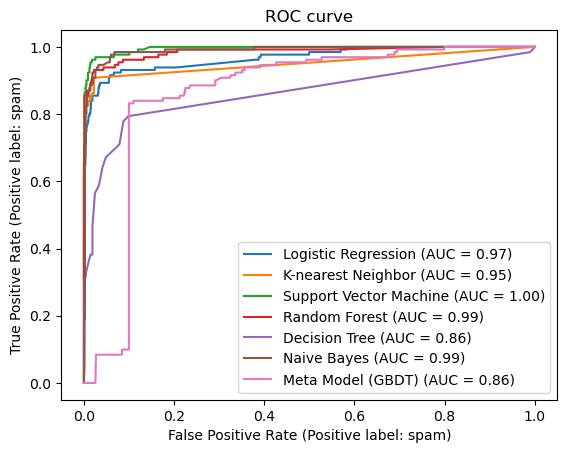

In [59]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

_, ax = plt.subplots()

models = [
    ("Logistic Regression", tuned_lr),
    ("K-nearest Neighbor", tuned_knn),
    ("Support Vector Machine", tuned_svc),
    ("Random Forest", tuned_rf),
    ("Decision Tree", tuned_dt),
    ("Naive Bayes", tuned_nb),
    ("Meta Model (GBDT)", final_meta),
]

model_displays = {}
for name, pipeline in models:
    if name == "Naive Bayes":
        model_displays[name] = RocCurveDisplay.from_estimator(
        pipeline, X_test_tf_arr, y_test, ax=ax, name=name
    )
        
    elif name == "Meta Model (GBDT)":
        model_displays[name] = RocCurveDisplay.from_estimator(
        pipeline, stack_test_df, y_test, ax=ax, name=name
    )
        
    else:
        model_displays[name] = RocCurveDisplay.from_estimator(
            pipeline, X_test_tf, y_test, ax=ax, name=name
        )
    
_ = ax.set_title("ROC curve")
plt.savefig("auc")

## Comparison 

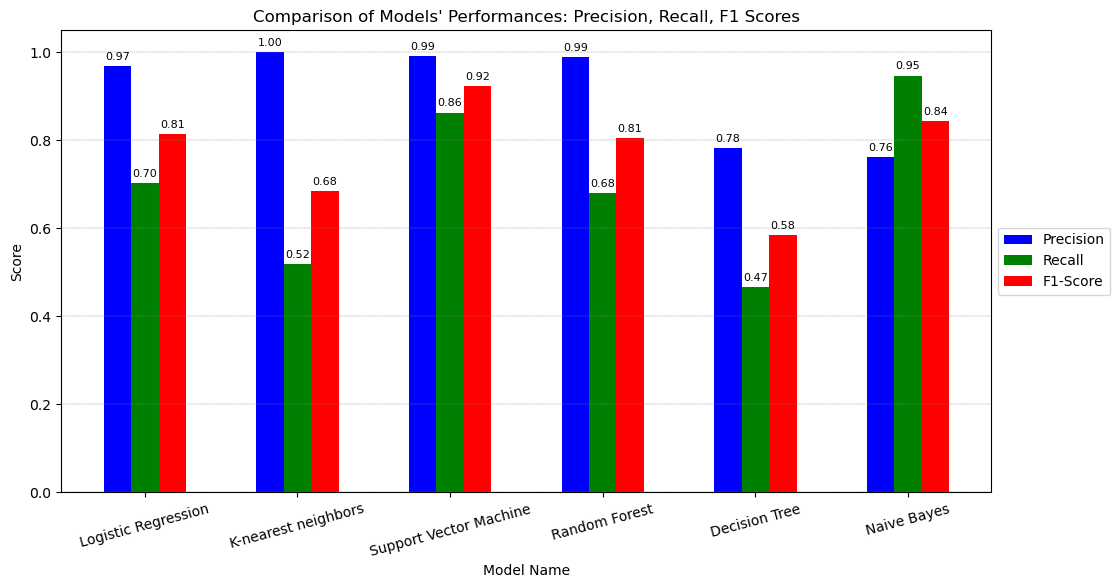

In [60]:
# Sample data (replace with your actual values)
model_names = ["Logistic Regression", "K-nearest neighbors", 
                  "Support Vector Machine", "Random Forest", 
                  "Decision Tree", "Naive Bayes"]

metrics = ["Precision", "Recall", "F1-Score"]

data = {
    "Precision": tuned_prec,
    "Recall": tuned_rec,
    "F1-Score": tuned_f1
}

# Define number of models and width of each bar
num_models = len(model_names)
bar_width = 0.18 # Adjust bar width as needed

# Create x-axis positions for grouped bars
index = range(num_models)
x = [i for i in index]  # Common x-axis positions

# Create the bar plot
plt.figure(figsize=(12, 6))

# Nested loop for bar positions
bar_positions = [i - bar_width * (len(metrics) - 1) / 2 + j * bar_width for j in range(len(metrics)) for i in index]  

# Colors for each metric
metric_colors = ['b', 'g', 'r']  

# Create bars for each metric
for metric_idx, metric in enumerate(metrics):
    plt.bar(bar_positions[metric_idx * num_models : (metric_idx + 1) * num_models], data[metric], bar_width, label=metric, color=metric_colors[metric_idx])

    # Add value labels above each bar
    for i, value in enumerate(data[metric]):
        y_pos = data[metric][i] + 0.01  # Adjust y-offset for better visibility
        plt.text(bar_positions[metric_idx * num_models + i], y_pos, f"{value:.2f}", ha='center', va='bottom', fontsize=8)  # Format value with 2 decimals
        
# Customize the plot
plt.xlabel("Model Name")
plt.ylabel("Score")
plt.title("Comparison of Models' Performances: Precision, Recall, F1 Scores")
plt.xticks(x, model_names, rotation=15)  # Set common x-axis labels with rotation
plt.grid(axis="y", color = 'gray', linestyle = '--', linewidth = 0.3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('perfomance')

# Display the plot
plt.show()

### Tuned models with Meta model

In [61]:
acc_data

NameError: name 'acc_data' is not defined

In [1]:
tuned_acc_plot = ["Logistic Regression", "K-nearest neighbors", 
                  "Support Vector Machine", "Random Forest", 
                  "Decision Tree", "Naive Bayes", "Meta model (GBDT)"]

In [4]:
# Create bar plot
plt.figure(figsize=(10, 6))

bar_width = 0.5

for i in range(len(acc_data)):
    plt.bar(tuned_acc_plot[i], acc_data[i], bar_width)
    
    # add value on top of each bar
    y_pos = acc_data[i] + 0.01
    plt.text(tuned_acc_plot[i], y_pos, f"{acc_data[i]:.2f}", ha='center', va='bottom', fontsize=8)

# Customize the plot
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy comparison of 6 base models and Meta model")
plt.xticks(rotation=15)  # Rotate x-axis labels for readability if many models
plt.grid(axis="y", color = 'gray', linestyle = '--', linewidth = 0.3)
plt.savefig("accuracy_performance")

# Display the plot
plt.show()

NameError: name 'acc_data' is not defined

<Figure size 1000x600 with 0 Axes>